In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors

In [37]:
#---------------
#Métodos para graficar resultados en mapa de calor
#---------------
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [38]:
#Lectura de matrices de expectativas y resultados
df_exp = pd.read_csv("/content/expected.csv", sep=";")
df_res = pd.read_csv("/content/clasificacion_all.csv", 
                     names= ['imagenet_id','image_name','alterationType','alterationLevel','prediction'],
                     header=None,
                     sep=";")

#traductor de Id de clases de imageNet a nombres
traductor = {"n02111129":"Leonberg", "n02701002":"ambulance", "n07742313":"Granny_Smith", "n07613480": "trifle" }

#Genera clave para unir ambos dataframes
df_exp["pk"] = df_exp["realClass"] + df_exp["alterationType"] + df_exp["alterationLevel"].astype(str)

# traduce clase Id de ImageNet a texto
df_res["label"] = df_res.apply(lambda x: traductor[x["imagenet_id"]], axis=1)

## **SECCIÓN DE VALIDACIONES**
Realiza visualizaciones de datos para verificar que la carga haya sido la esperada

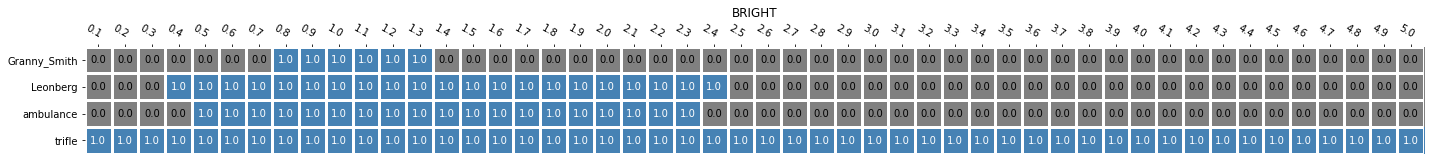

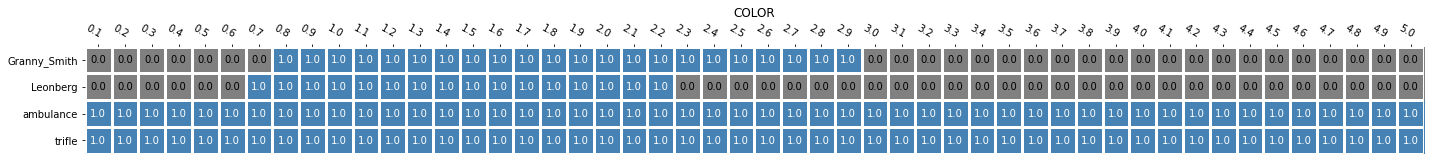

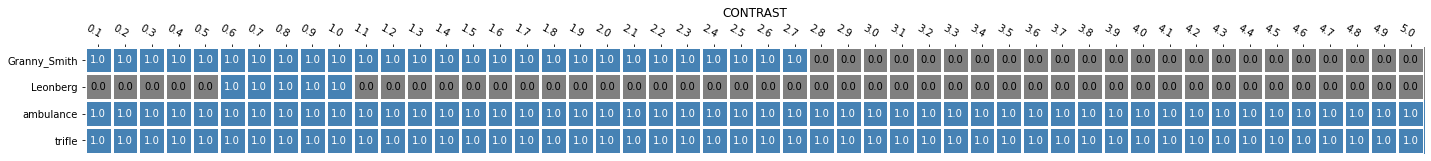

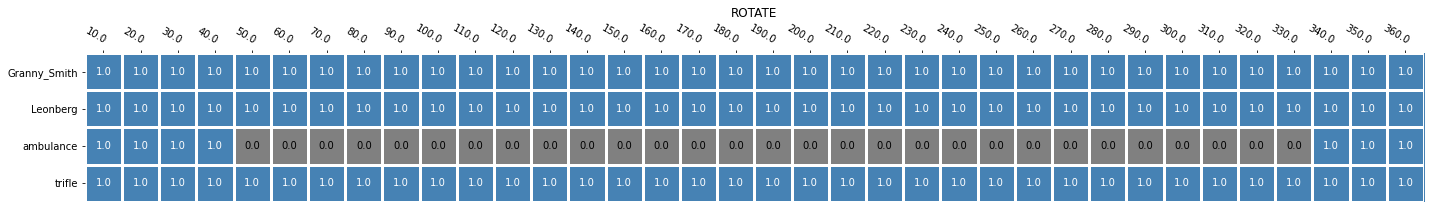

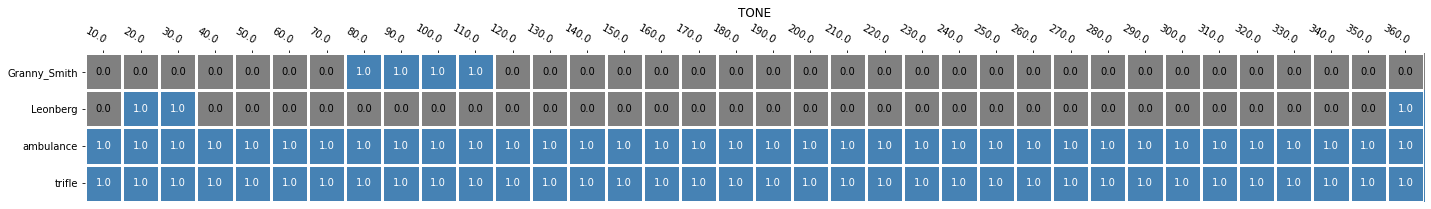

In [39]:
cmap = colors.ListedColormap(['gray', 'steelblue'])
bounds = [0., 0.5, 1.]
norm = colors.BoundaryNorm(bounds, cmap.N)

#Validación de matriz de expectativas escenario especifico
rowNames = df_exp[df_exp["contextId"] == "Especifico"].groupby(by=["alterationType", "realClass"]).agg({
                          'isSamePrediction':'sum',
                          'alterationLevel':'count',
                         }).reset_index().pivot(index=["alterationType"], columns="realClass", values=["isSamePrediction"]).reset_index()["alterationType"]

for alterationType in rowNames:
  graph_level = df_exp[(df_exp["contextId"] == "Especifico") & (df_exp["alterationType"] == alterationType)].groupby(by=["realClass", "alterationLevel"])["isSamePrediction"].sum().reset_index().pivot(index=["realClass"], columns="alterationLevel", values="isSamePrediction").reset_index()
  dataToShow = graph_level.iloc[:,1:]
  rowNames = graph_level["realClass"]
  colNames = list(dataToShow.columns)

  fig, ax = plt.subplots(figsize=(30,3))
  plt.title(alterationType)
  im, cbar = heatmap(dataToShow, rowNames, colNames, ax=ax,
                     cmap=cmap, norm=norm, cbarlabel="Mantener Predicción")
  texts = annotate_heatmap(im, valfmt="{x:.1f}")
  plt.delaxes(fig.axes[1]) 
  plt.show()

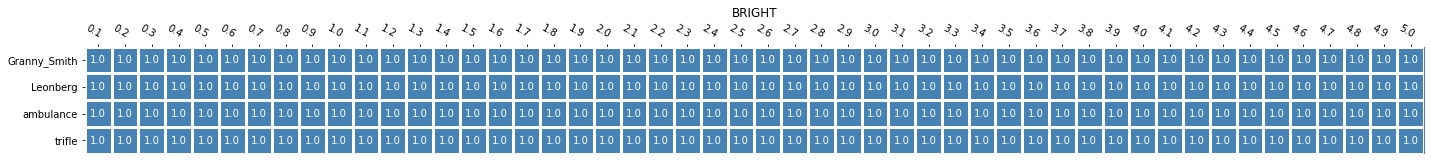

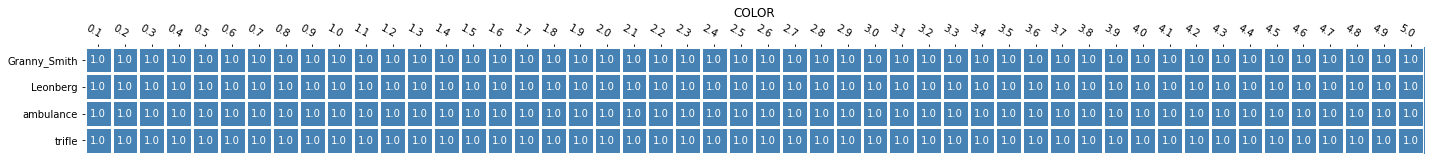

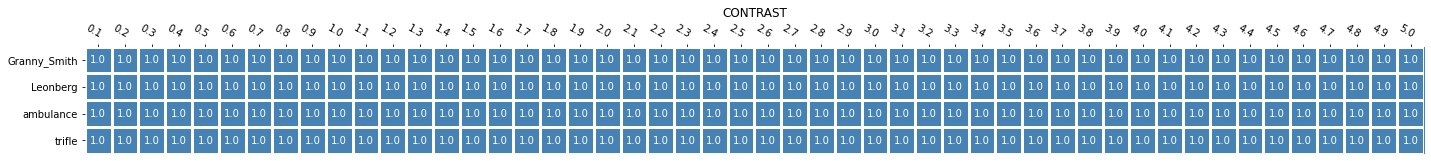

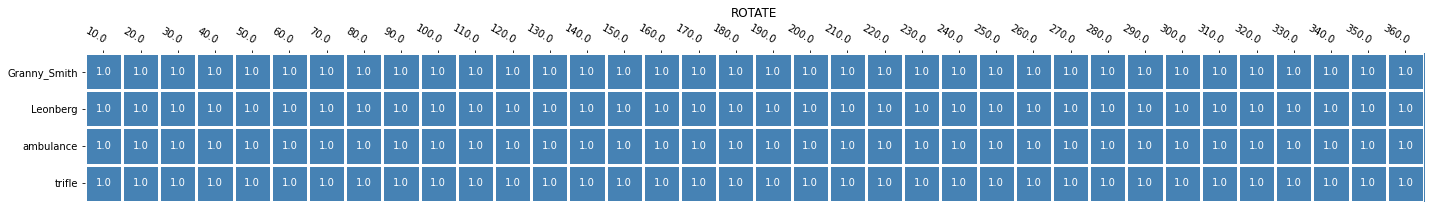

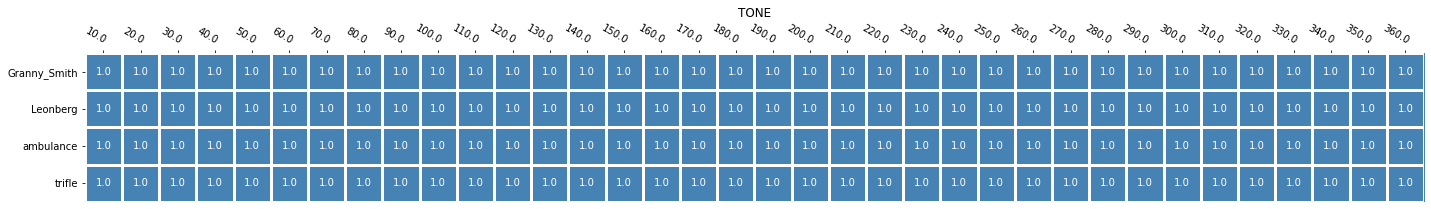

In [40]:
cmap = colors.ListedColormap(['gray', 'steelblue'])
bounds = [0., 0.5, 1.]
norm = colors.BoundaryNorm(bounds, cmap.N)

#Validación de matriz de expectativas escenario especifico
rowNames = df_exp[df_exp["contextId"] == "General"].groupby(by=["alterationType", "realClass"]).agg({
                          'isSamePrediction':'sum',
                          'alterationLevel':'count',
                         }).reset_index().pivot(index=["alterationType"], columns="realClass", values=["isSamePrediction"]).reset_index()["alterationType"]

for alterationType in rowNames:
  graph_level = df_exp[(df_exp["contextId"] == "General") & (df_exp["alterationType"] == alterationType)].groupby(by=["realClass", "alterationLevel"])["isSamePrediction"].sum().reset_index().pivot(index=["realClass"], columns="alterationLevel", values="isSamePrediction").reset_index()
  dataToShow = graph_level.iloc[:,1:]
  rowNames = graph_level["realClass"]
  colNames = list(dataToShow.columns)

  fig, ax = plt.subplots(figsize=(30,3))

  plt.title(alterationType)
  im, cbar = heatmap(dataToShow, rowNames, colNames, ax=ax,
                     cmap=cmap, norm=norm, cbarlabel="Merad Index")
  texts = annotate_heatmap(im, valfmt="{x:.1f}")
  plt.delaxes(fig.axes[1]) 
  plt.show()

In [41]:
#Validación de matriz de realidades
df_res.groupby(by=["alterationType", "imagenet_id"]).count().reset_index().pivot(index=["alterationType"], columns="imagenet_id", values=["image_name"])

image_name                              
imagenet_id     n02111129 n02701002 n07613480 n07742313
alterationType                                         
BRIGHT               2500      2500      2500      2500
COLOR                2500      2500      2500      2500
CONTRAST             2500      2500      2500      2500
ORIGINAL               50        50        50        50
ROTATE               1800      1800      1800      1800
TONE                 1800      1800      1800      1800

In [42]:
#Validación de matriz de realidades
df_res.groupby(by=["alterationLevel", "alterationType"]).agg({
                          'prediction':'count',
                         }).reset_index().pivot(index=["alterationLevel"], columns="alterationType", values=["prediction"])

prediction                                       
alterationType      BRIGHT  COLOR CONTRAST ORIGINAL ROTATE   TONE
alterationLevel                                                  
0.0                    NaN    NaN      NaN    200.0    NaN    NaN
0.1                  200.0  200.0    200.0      NaN    NaN    NaN
0.2                  200.0  200.0    200.0      NaN    NaN    NaN
0.3                  200.0  200.0    200.0      NaN    NaN    NaN
0.4                  200.0  200.0    200.0      NaN    NaN    NaN
...                    ...    ...      ...      ...    ...    ...
320.0                  NaN    NaN      NaN      NaN  200.0  200.0
330.0                  NaN    NaN      NaN      NaN  200.0  200.0
340.0                  NaN    NaN      NaN      NaN  200.0  200.0
350.0                  NaN    NaN      NaN      NaN  200.0  200.0
360.0                  NaN    NaN      NaN      NaN  200.0  200.0

[87 rows x 6 columns]

In [43]:
#Validación de matriz de realidades - label
df_res.groupby(by=["alterationType", "alterationLevel"]).agg({
                          'prediction':'count',
                         }).reset_index().pivot(index=["alterationType"], columns="alterationLevel", values=["prediction"])

prediction                       ...                            
alterationLevel      0.0    0.1    0.2    0.3    ...  330.0  340.0  350.0  360.0
alterationType                                   ...                            
BRIGHT                 NaN  200.0  200.0  200.0  ...    NaN    NaN    NaN    NaN
COLOR                  NaN  200.0  200.0  200.0  ...    NaN    NaN    NaN    NaN
CONTRAST               NaN  200.0  200.0  200.0  ...    NaN    NaN    NaN    NaN
ORIGINAL             200.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
ROTATE                 NaN    NaN    NaN    NaN  ...  200.0  200.0  200.0  200.0
TONE                   NaN    NaN    NaN    NaN  ...  200.0  200.0  200.0  200.0

[6 rows x 87 columns]

## **SECCIÓN DE CALCULOS**
Se realiza los siguientes cálculos:

*   **result:** asigna "1" en caso que predicción con alteración sea igual a etiqueta real, de lo contrario asigna 0
*   **cell_calc_net:** Diferencia al cuadrado entre el valor esperado en la matriz de expectativas (1 en caso de que predicción sobre imagen alterada se mantenta, 0 en caso contrario) y el promedio de la clasificación de cada imagen (1 en caso de que la predicción sobre la imagen alterada sea igual a la predicción sin alteración, en caso contrario 0)
*   **cell_calc_merad** Raiz Cuadrada del promedio de cell_calc_net para el grupo que se está evaluando



In [44]:
# calculamos 1 igual prediccion real = prediccion con alteracion
df_res["result"] = df_res.apply(lambda x: 1.0 if x["prediction"] == x["label"] else 0.0 , axis=1 )

In [45]:
# generamos subconjunto solo con predicciones originales
df_res_img_subset = df_res[(df_res['alterationType'] == "ORIGINAL")]
df_res_img_subset = df_res_img_subset.rename(columns={"prediction": "prediction_original"})

In [46]:
# crea columna con label original
df_res = pd.merge(df_res, df_res_img_subset[["image_name","prediction_original"]], on="image_name")

In [47]:
#CONTROL: cantidad de claseReal = clasePrediccionOriginal
df_res[(df_res["alterationType"] == "ORIGINAL") & (df_res["label"] == df_res["prediction_original"])].groupby(by=["label"]).count()

,imagenet_id,image_name,alterationType,alterationLevel,prediction,result,prediction_original
label,,,,,,,
Granny_Smith,37,37,37,37,37,37,37
Leonberg,46,46,46,46,46,46,46
ambulance,43,43,43,43,43,43,43
trifle,44,44,44,44,44,44,44


In [48]:
# excluye filas con prediccion original en dataset de resultados reales
df_res = df_res[df_res["alterationType"] != "ORIGINAL"]

In [49]:
# tomamos solamente prediccion original = prediccion real
df_res_paso1 = df_res[df_res["label"] == df_res["prediction_original"]]
df_res_paso1["result_avg"] = df_res_paso1["result"]
df_res_paso1["result_total"] = df_res_paso1["result"]
df_res_paso1["result_sum"] = df_res_paso1["result"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [50]:
df_res_paso1["pk"] = df_res_paso1["label"] + df_res_paso1["alterationType"] + df_res_paso1["alterationLevel"].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
#cálculo de matriz de realidad
df_res_paso2 = df_res_paso1.groupby(by = ["pk","label", "alterationType", "alterationLevel"],as_index = False).agg({
                          'result_sum':'sum',
                          'result_avg':'mean',
                          'result_total':'count'
                         #'d': lambda x: x.max() - x.min()
                         }).reset_index()

In [52]:
#crea matriz final
df_final = pd.merge(df_exp, df_res_paso2[["pk","result_sum","result_avg","result_total"]], on="pk", how="left")

In [53]:
df_final["cell_calc_net"] = df_final.apply(lambda x:  (0 if x["result_avg"] == np.nan else (x["result_avg"] - x["isSamePrediction"]))**2, axis=1)

In [54]:
# método que calcula los datos para los gráficos
def get_pivot(contextId, nameInRow, nameInColumn, dfFiltered = df_final):
  temp1 = (dfFiltered[dfFiltered["contextId"] == contextId].groupby(by=[nameInColumn,nameInRow], as_index=False)["cell_calc_net"].mean())

  #agrega totales
  totalRow = (dfFiltered[dfFiltered["contextId"] == contextId].groupby(by=[nameInColumn], as_index=False)["cell_calc_net"].mean()).reset_index()
  totalColumn = (dfFiltered[dfFiltered["contextId"] == contextId].groupby(by=[nameInRow], as_index=False)["cell_calc_net"].mean()).reset_index()
  totalFinal = dfFiltered[dfFiltered["contextId"] == contextId]["cell_calc_net"].mean()

  ##add total 
  totalColumn[nameInColumn] = "TOTAL2"
  totalRow[nameInRow] = "TOTAL"
  #print(totalColumn[[nameInColumn,nameInRow,"cell_calc_net"]])
  #temp1.append("Total") = 0
  #print(totalRow)

  #print(totalFinal)
               
  #temp1.insert(totalRow)
  #temp1 = temp1[[nameInColumn, nameInRow, "cell_calc_net"]]
  
  temp1 = temp1.append(totalColumn[[nameInColumn,nameInRow,"cell_calc_net"]], ignore_index=True)
  temp1 = temp1.append(totalRow[[nameInColumn,nameInRow,"cell_calc_net"]], ignore_index=True)
  temp1 = temp1.append([{nameInColumn: "TOTAL2", nameInRow: "TOTAL", 'cell_calc_net': totalFinal}], ignore_index=True)
  #print(temp1[temp1[nameInRow] == "TOTAL"])

  #calc mread index
  temp1["cell_calc_merad"] = temp1.apply(lambda x: 1-math.sqrt(x["cell_calc_net"]),  axis=1)

  #reordena columna
  temp1 = temp1.pivot(index=nameInRow, columns=nameInColumn, values='cell_calc_merad').reset_index()
  temp1["TOTAL"] = temp1["TOTAL2"]
  temp1 = temp1.drop("TOTAL2", 1)

  #reordena fila
  rowToRemove = temp1[temp1[nameInRow] == "TOTAL"]
  temp1 = temp1[temp1[nameInRow] != "TOTAL"]
  temp1 = temp1.append(rowToRemove, ignore_index=True)
  

  
  return temp1

#para probar:
#get_pivot("Especifico", "alterationType", "realClass")
#df_final[df_final["realClass"] == "trifle"].groupby(by=["contextId","alterationType"])["cell_calc_net"].mean().apply(lambda x: 1-math.sqrt(x))

In [55]:
get_pivot("General", "alterationType", "realClass")

realClass,alterationType,Granny_Smith,Leonberg,ambulance,trifle,TOTAL
0,BRIGHT,0.314706,0.327336,0.681540,0.414836,0.415633
1,COLOR,0.507737,0.438810,0.793193,0.735698,0.590769
2,CONTRAST,0.404411,0.344191,0.773928,0.638658,0.508449
3,ROTATE,0.586492,0.210985,0.139142,0.361599,0.303192
4,TONE,0.138308,0.141503,0.207490,0.221778,0.176405
5,TOTAL,0.376800,0.299875,0.484239,0.464685,0.401852


## **SECCIÓN DE RESULTADOS**
Se generan mapas de calor para mostrar gráficamente los resultados:



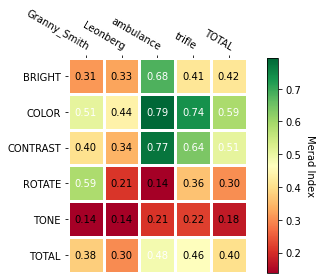

In [56]:
#Grafico General
temp2 = get_pivot("General", "alterationType", "realClass")
dataToShow = temp2.iloc[:,1:]
rowNames = temp2["alterationType"]
colNames = list(dataToShow.columns)

fig, ax = plt.subplots()

im, cbar = heatmap(dataToShow, rowNames, colNames, ax=ax,
                   #cmap="YlGn", cbarlabel="Merad Index")
                   cmap="RdYlGn", cbarlabel="Merad Index")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('/content/result_inmutable_resume.png', transparent=True, format ="png")
plt.show()


In [57]:
#Grafico Especifico

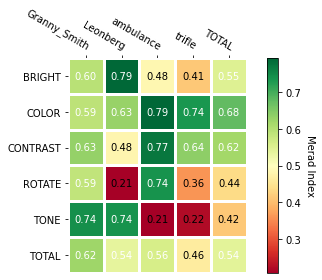

In [58]:
temp2 = get_pivot("Especifico", "alterationType", "realClass")
dataToShow = temp2.iloc[:,1:]
rowNames = temp2["alterationType"]
colNames = list(dataToShow.columns)

fig, ax = plt.subplots()

im, cbar = heatmap(dataToShow, rowNames, colNames, ax=ax,
                   #cmap="YlGn", cbarlabel="Merad Index")
                   cmap="RdYlGn", cbarlabel="Merad Index")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('/content/result_specific_resume.png', transparent=True, format ="png")
plt.show()

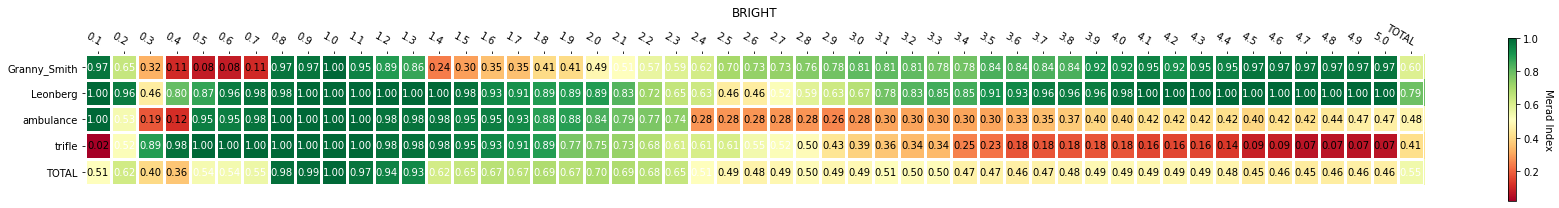

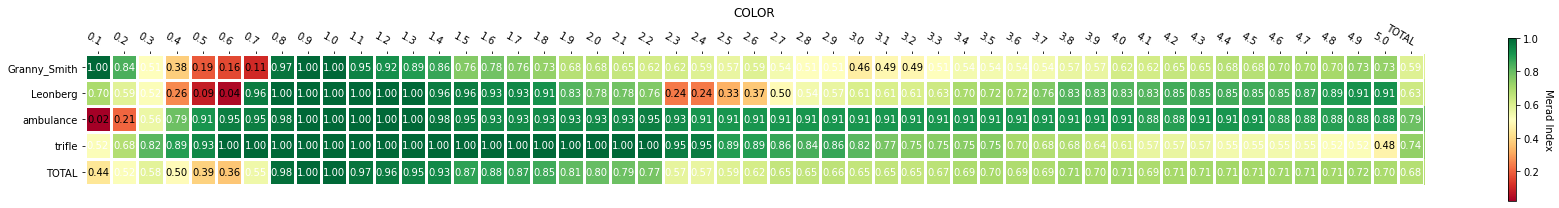

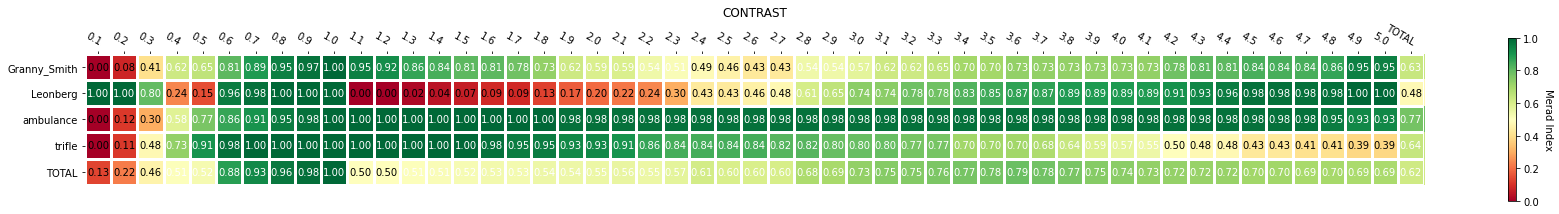

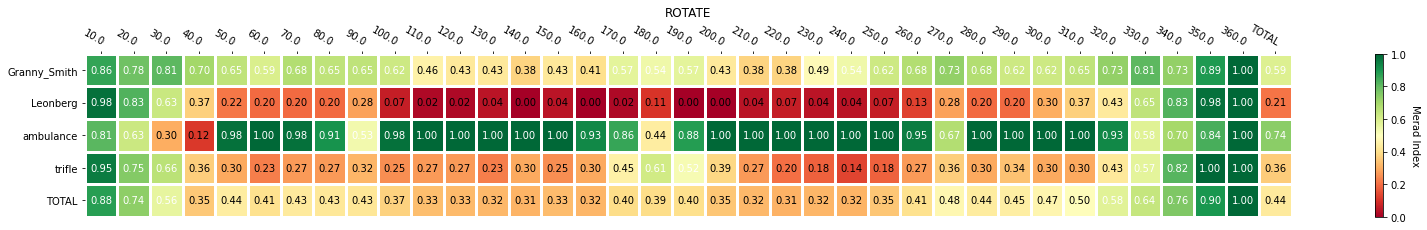

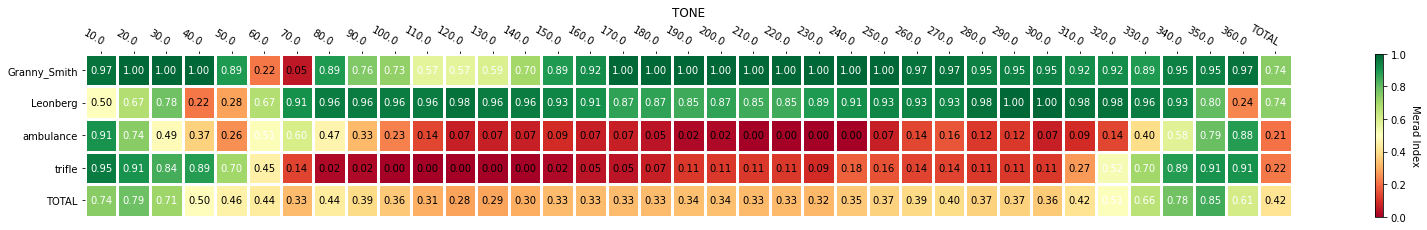

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:428: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


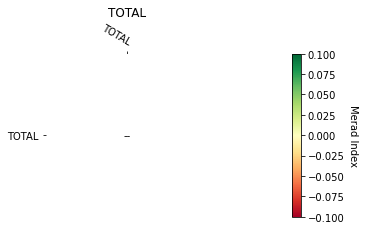

In [61]:
rowNames = get_pivot("Especifico", "alterationType", "realClass")["alterationType"]

for alterationType in rowNames:
  graph_level = get_pivot("Especifico", "realClass", "alterationLevel", dfFiltered=df_final[df_final["alterationType"] == alterationType]) #  df_final[(df_final["contextId"] == "Especifico") & (df_final["alterationType"] == alterationType)].groupby(by=["realClass","alterationLevel"], as_index=False)["cell_calc_net"].mean().pivot(index='realClass', columns='alterationLevel', values='cell_calc_net').reset_index()
  dataToShow = graph_level.iloc[:,1:]
  rowNames = graph_level["realClass"]
  #rowNames = graph_level["alterationLevel"]
  colNames = list(dataToShow.columns)

  fig, ax = plt.subplots(figsize=(30,3))

  plt.title(alterationType)

  im, cbar = heatmap(dataToShow, rowNames, colNames, ax=ax,
                    #cmap="YlGn", cbarlabel="Merad Index")
                    cmap="RdYlGn", cbarlabel="Merad Index")
  texts = annotate_heatmap(im, valfmt="{x:.1f}")

  #fig = plt.figure(figsize=(10, 10))
  #fig.tight_layout()
  plt.savefig('/content/result_specific_' + alterationType.lower() + '.png', transparent=True, format ="png")
  plt.show()

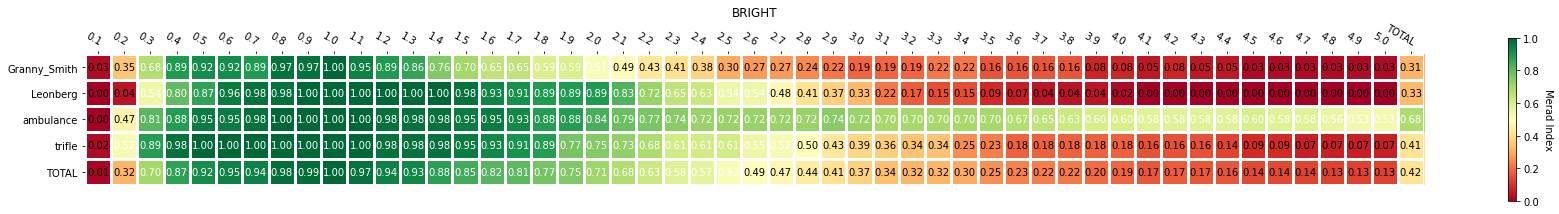

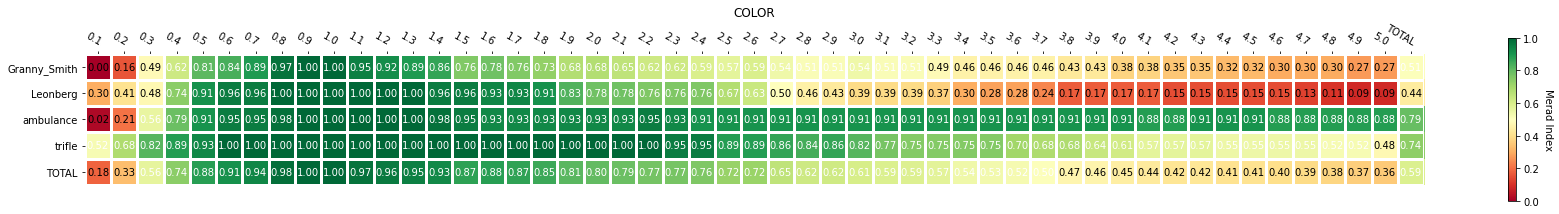

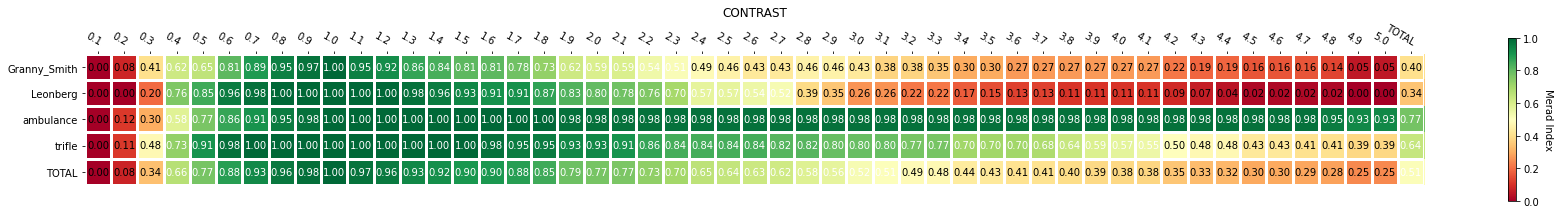

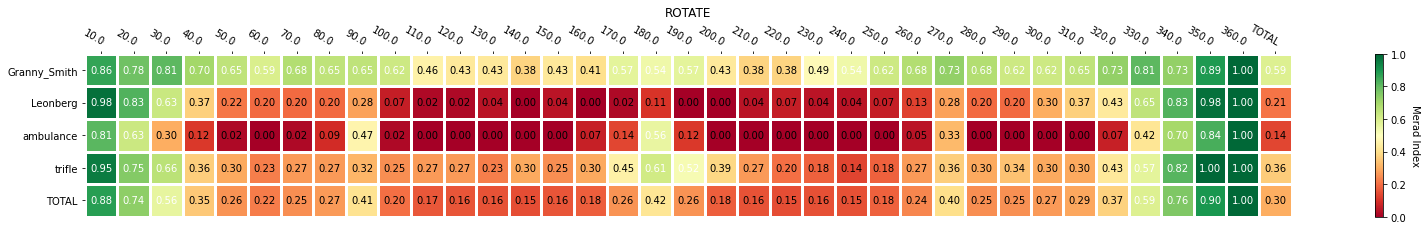

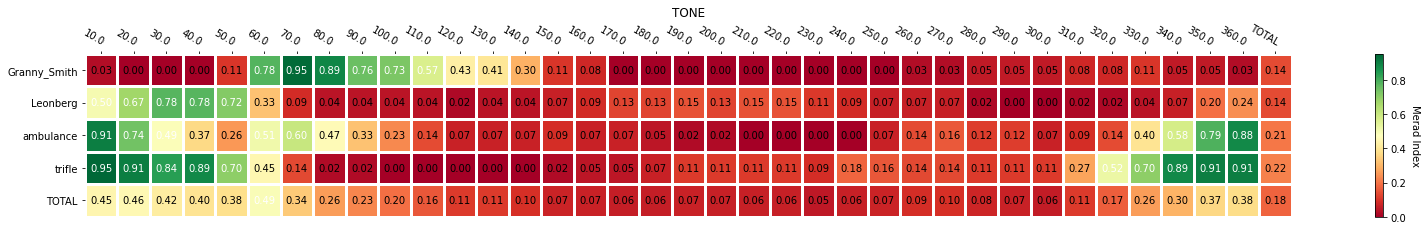

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:428: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


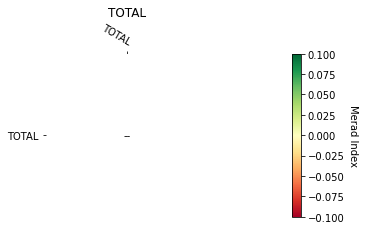

In [62]:
rowNames = get_pivot("General", "alterationType", "realClass")["alterationType"]
colNames = list(dataToShow.columns)

for alterationType in rowNames:
  graph_level = get_pivot("General", "realClass", "alterationLevel", dfFiltered=df_final[df_final["alterationType"] == alterationType]) #  df_final[(df_final["contextId"] == "Especifico") & (df_final["alterationType"] == alterationType)].groupby(by=["realClass","alterationLevel"], as_index=False)["cell_calc_net"].mean().pivot(index='realClass', columns='alterationLevel', values='cell_calc_net').reset_index()
  dataToShow = graph_level.iloc[:,1:]
  rowNames = graph_level["realClass"]
  #rowNames = graph_level["alterationLevel"]
  colNames = list(dataToShow.columns)

  fig, ax = plt.subplots(figsize=(30,3))

  plt.title(alterationType)

  im, cbar = heatmap(dataToShow, rowNames, colNames, ax=ax,
                    #cmap="YlGn", cbarlabel="Merad Index")
                    cmap="RdYlGn", cbarlabel="Merad Index")
  texts = annotate_heatmap(im, valfmt="{x:.1f}")

  #fig = plt.figure(figsize=(10, 10))
  #fig.tight_layout()
  plt.savefig('/content/result_general_' + alterationType.lower() + '.png', transparent=True, format ="png")
  plt.show()